# 1. Import Data
First, let's use the pandas library to import the data and store it. It is quite obvious that the first sample is a fluke, and was thus ignored.

In [35]:
## Import Raw Data, convert to_datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as fft
import scipy.signal as sig

from diptest import diptest
from sklearn.cluster import KMeans
from seaborn import kdeplot
# import scipy.stats as stats

import mylib as my


## IMPORT
dl1 = my.import_csv("../data/DL1March_May_24.csv")
dl3 = my.import_csv("../data/DL3March_May_24.csv")

## CONSTANTS
from myconstants import *

# DONT FORGET TO USE %run *.ipynb TO RUN OTHER JUPYTER NB

In [ ]:
# %run statistical_analysis.ipynb
# %run time_series_analysis.ipynb
# %run autocorrelation_psd.ipynb
# separate these perhaps

# 2. CPU Usage Correlation
Thanks to Steven Richardson, we have some CPU usage data since August 23rd 2023 to August 14th 2024. We have this data for various servers including: Bermuda, Capsim, Pampas, Saintsaens1, Spinifex, Widor, Messiaen, and Bamboo. A sample was taken every minute or so. In this section, we will explore potential correlations between CPU Usage percentage and power consumption. Unfortunately, we are in the dark as to which server corresponds to which distribution board.

## Import Raw Data
As detailed in correspondance, only Bamboo, Bermuda, Pampas, and Spinifex have the correct data for the correct time frame we are analysing. For this reason, the rest will be omitted for now. We will truncate as necessary.

In [36]:
## Import Data
bamboo = my.import_cpu_usage('../data/CPU-Data-ee-bamboo.csv', ref=dl1, truncate=True)

bermuda = my.import_cpu_usage('../data/CPU-Data-ee-bermuda.csv', ref=dl1, truncate=True)

capsim = my.import_cpu_usage('../data/CPU-Data-ee-capsim.csv', ref=dl1, truncate=False)

messiaen = my.import_cpu_usage('../data/CPU-Data-ee-messiaen.csv', ref=dl1, truncate=False)

pampas = my.import_cpu_usage('../data/CPU-Data-ee-pampas.csv', ref=dl1, truncate=True)

saintsaens = my.import_cpu_usage('../data/CPU-Data-ee-saintsaens1.csv', ref=dl1, truncate=False)

spinifex = my.import_cpu_usage('../data/CPU-Data-ee-spinifex.csv', ref=dl1, truncate=True)

widor = my.import_cpu_usage('../data/CPU-Data-ee-widor.csv', ref=dl1, truncate=False)

## To Truncate: add .truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                #   after=pd.Timestamp('2024-06-22 00:00:00+00:00'))

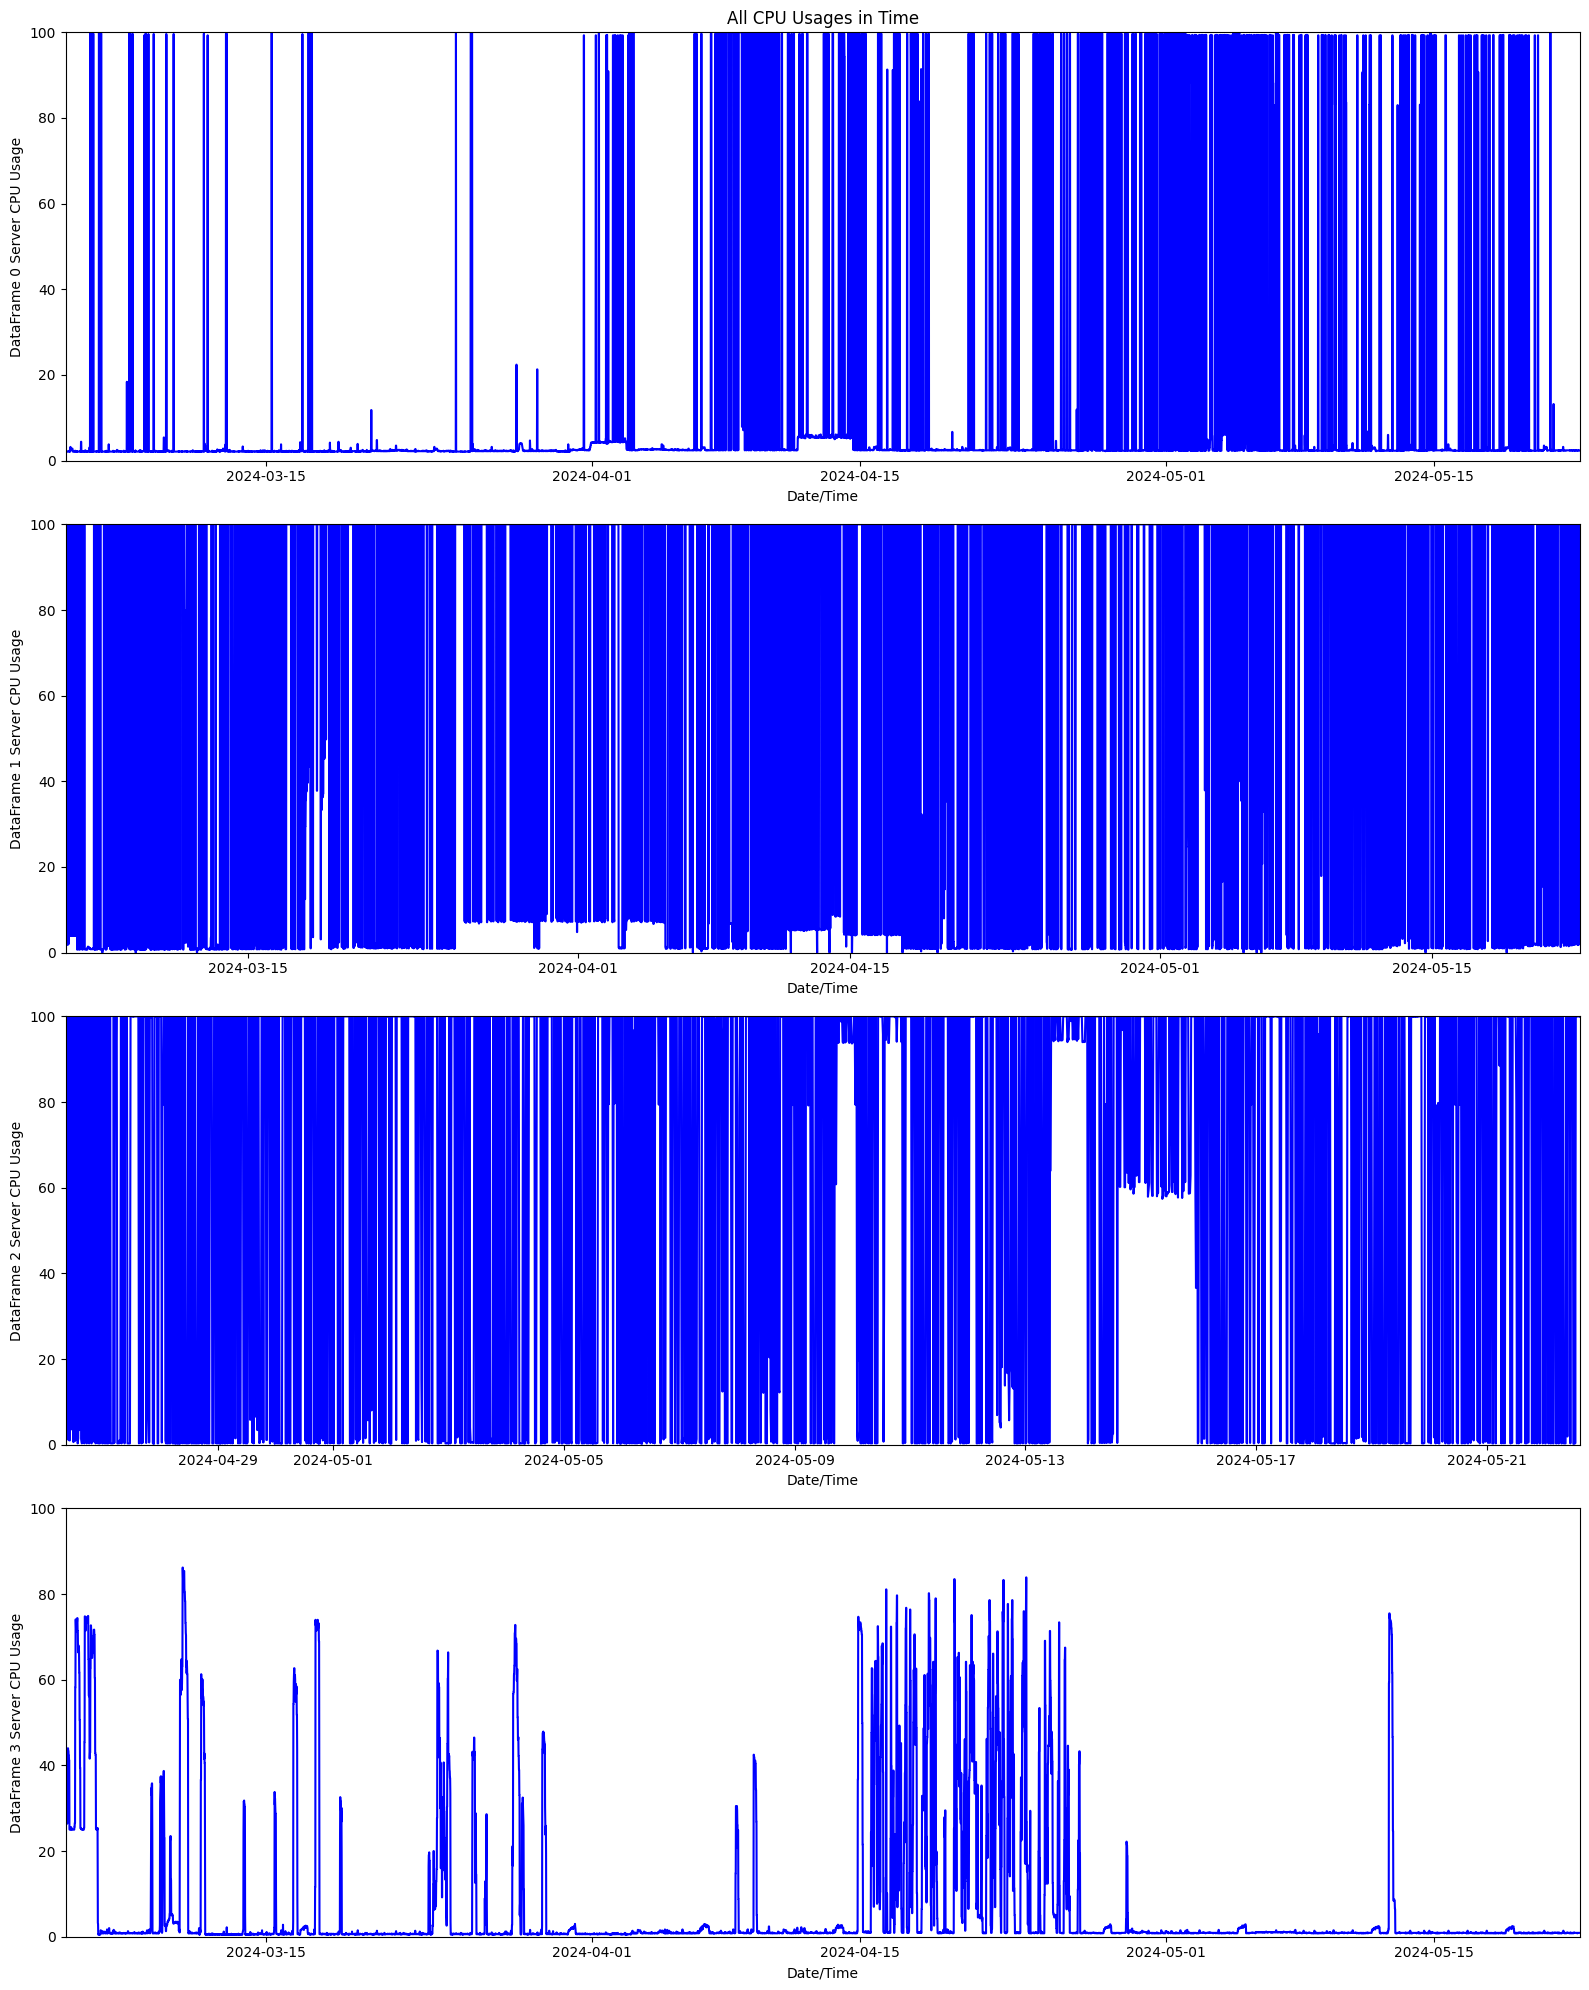

In [37]:
server_names = ['bamboo', 'bermuda', 'pampas', 'spinifex']
my.plot_raw_data([bamboo, bermuda, pampas, spinifex], figsize=FIGSIZE, columnname='cpu.total')

## Obtain Correlation Coefficients
In order to obtain a relatively reliable correlation coefficient, it is pertinent to average the CPU usages over the same sampling time as the power consumption. All samples have been taken approximately 15 minutes apart from each other: this has been empirically determined.

As the samples from the distribution boards are spaced apart by 30mins, we round the CPU usage samples to that time

In [38]:
## CORRELATION OVER 30MINS
bamboo_averages = {}
bermuda_averages = {}
pampas_averages = {}
spinifex_averages = {}

my.cpu_corr_by_ref(bamboo['cpu.total'], dl1[HEADER], '30min', bamboo_averages, name='Bamboo', normalize=False)
my.cpu_corr_by_ref(bermuda['cpu.total'], dl1[HEADER], '30min', bermuda_averages, name='Bermuda', normalize=False)
my.cpu_corr_by_ref(pampas['cpu.total'], dl1[HEADER], '30min', pampas_averages, name='Pampas', normalize=False)
my.cpu_corr_by_ref(spinifex['cpu.total'], dl1[HEADER], '30min', spinifex_averages, name='Spinifex', normalize=False)

Bamboo 30min Correlation: -0.13650932387530296
Bermuda 30min Correlation: -0.044562480020609446
Pampas 30min Correlation: 0.055691286602528235
Spinifex 30min Correlation: -0.055336613901943735


We can also change it so that both datasets are averaged over a day:

In [39]:
dl1_averages = dl1[HEADER].groupby(dl1.index.normalize()).mean()

my.cpu_corr_by_ref(bamboo['cpu.total'], dl1_averages, '1d', bamboo_averages, name='Bamboo', normalize=True)
my.cpu_corr_by_ref(bermuda['cpu.total'], dl1_averages, '1d', bermuda_averages, name='Bermuda', normalize=True)
my.cpu_corr_by_ref(pampas['cpu.total'], dl1_averages, '1d', pampas_averages, name='Pampas', normalize=True)
my.cpu_corr_by_ref(spinifex['cpu.total'], dl1_averages, '1d', spinifex_averages, name='Spinifex', normalize=True)


Bamboo 1d Correlation: -0.30382868036454685
Bermuda 1d Correlation: -0.14664408869785947
Pampas 1d Correlation: 0.11916824359316434
Spinifex 1d Correlation: -0.08627101418731323


Or a week perhaps:

In [40]:
dl1_averages = dl1[HEADER].groupby(dl1.index.round('7d')).mean()

my.cpu_corr_by_ref(bamboo['cpu.total'], dl1_averages, '7d', bamboo_averages, name='Bamboo', normalize=False)
my.cpu_corr_by_ref(bermuda['cpu.total'], dl1_averages, '7d', bermuda_averages, name='Bermuda', normalize=False)
my.cpu_corr_by_ref(pampas['cpu.total'], dl1_averages, '7d', pampas_averages, name='Pampas', normalize=False)
my.cpu_corr_by_ref(spinifex['cpu.total'], dl1_averages, '7d', spinifex_averages, name='Spinifex', normalize=False)

Bamboo 7d Correlation: -0.5553798323303514
Bermuda 7d Correlation: -0.27600574115367293
Pampas 7d Correlation: 0.2958925134962965
Spinifex 7d Correlation: -0.11313671794312039


# 3. CPU Statistical Analysis
Just like before, we can use the *my.statistical_analysis* function to analyse the CPU Usages on different servers. It is quite obvious that all of the distributions are quite bad, as the CPU goes from idle to 100% usage constantly. Therefore, in order to save some time, we will analyse the daily average instead, which does lead to some more interesting results.

DATASET STATISTICS:
Mean: 16.412902626811594
Standard Deviation: 14.880513812288296
Minimum Value: 2.15
25th Percentile: 3.421614583333333
Median: 11.685416666666669
75th Percentile: 24.83020833333333
Maximum: 65.64999999999999
Skewness: 1.1810529114584905
Kurtosis: 0.7994863801599879

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.8600, p=3.569200652582343e-07
DAgostino and Pearsons Test: stat=17.5451, p=0.00015492472478634885
Kolmogorov-Smirnov Test: stat=0.17042531408648526, p=0.01680871052619981

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: weibull_min
Best p value: 0.4655160924877313
Parameters for the best fit: (0.6427213565372917, 2.1499999999999995, 13.182916957111214)


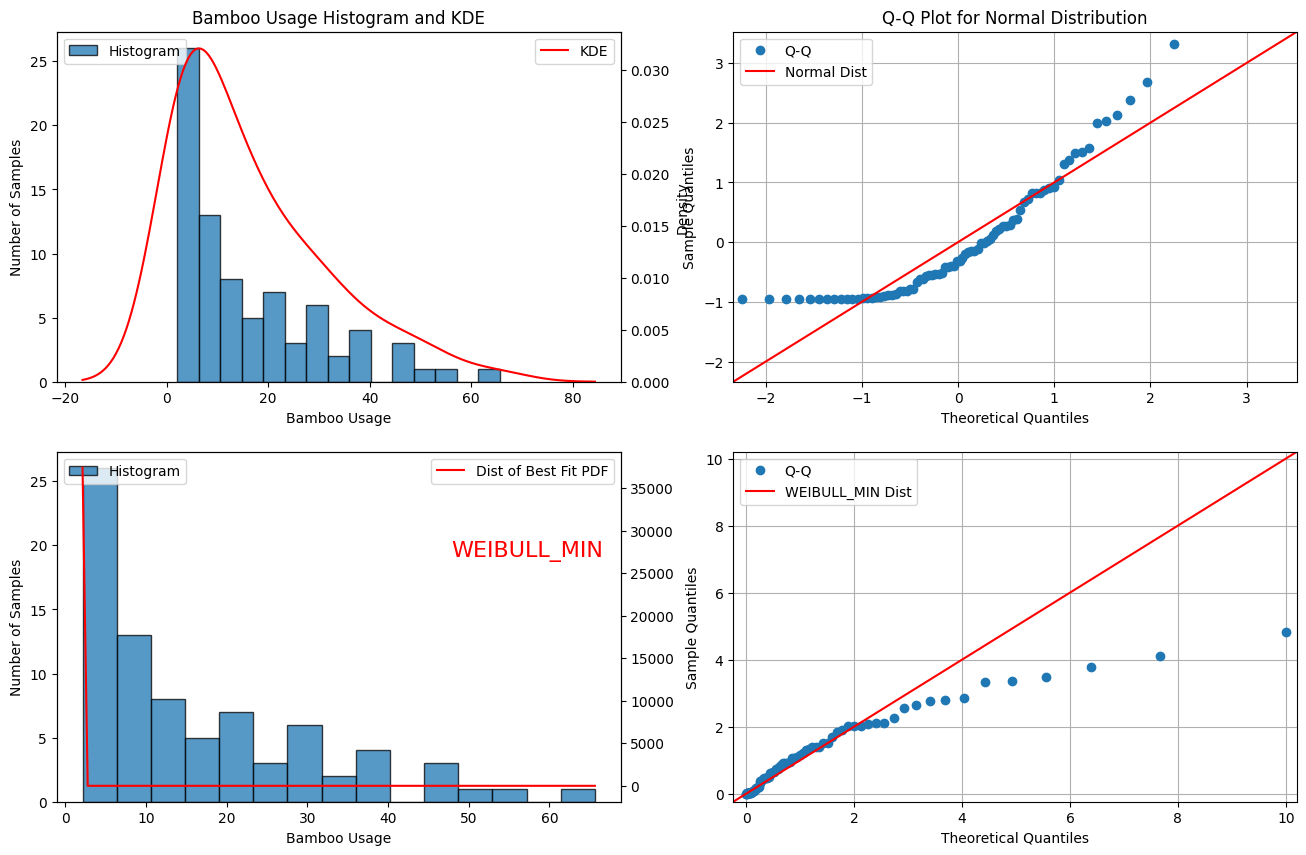

In [41]:
my.statistical_analysis(bamboo_averages['1d'], bins=15, header='Bamboo Usage') 
# ^ most interesting one - only uncomment next ones to take a look, but be warned it is slow and inconclusive

# my.statistical_analysis(bermuda['cpu.total'], header='Bermuda Usage')
# my.statistical_analysis(pampas['cpu.total'], header='Pampas Usage')
# my.statistical_analysis(spinifex['cpu.total'], header='Spinifex Usage')